## Plot climatological zonal-mean total column ozone

Comparing the CCMI2022 ensemble mean against the ensemble members and the nudged UM-UKCA ACSIS data.

In [1]:
import iris
import iris.analysis
import iris.quickplot as qplt
import iris.coord_categorisation
import iris.analysis
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import cf_units
import matplotlib.cm as cm
iris.FUTURE.date_microseconds = True

In [2]:
# define the locations of the various datasets
# CCMI2022 refD1 ensemble
ensdata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_Amon_UKESM1-StratTrop_refD1_r?i1p1f2_gn_19600101-20190101.nc'
# CCMI1 refC1
ccmidata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_monthly_UMUKCA-UCAM_refC1_r1i1p1_*.nc'
# UKCA model data from ACSIS project, nudged to ERA5
ukcadata='/home/ubuntu/Tutorials/UMvn13.0/data/u-*/apm.pp/*.pp'
# Bodeker Scientific TCO dataset - https://www.bodekerscientific.com/data/total-column-ozone
# this has been preprocessed into a single file using ncks, ncatted, and ncrcat
# for i in `ls *.nc`; do echo $i; ncks -O --mk_rec_dmn time $i $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a created,global,d,, $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,longitude,o,c,degrees_east $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,latitude,o,c,degrees_north $i; done
# ncrcat BSFilledTCO_V3.4.1_????_Monthly.nc ../BSFilledTCO_V3.4.1_Monthly.nc
obsdata='/home/ubuntu/Tutorials/UMvn13.0/data/Bodeker_3.4.1/*.nc'
# We would like to thank Bodeker Scientific, funded by the New Zealand Deep South National 
# Science Challenge, for providing the combined NIWA-BS total column ozone database.

In [3]:
# read-in the UM-UKCA pp data, TCO is in STASH code s50i219
ukca=iris.load_cube(ukcadata,iris.AttributeConstraint(STASH='m01s50i219'))

# 3x ensemble members for CCMI2022
inens=iris.load(ensdata,'toz')

/home/vagrant/.conda/envs/ukca/lib/python3.12/site-packages/iris/fileformats/rules.py:371: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/vagrant/.conda/envs/ukca/lib/python3.12/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'toz'
  warnings.warn(


In [4]:
# add the months to allow for aggregation
iris.coord_categorisation.add_month(ukca,'time')

# Only want 1995-2005 for a year-2000 climatology
# time constraints for extracting data
pdt1=iris.time.PartialDateTime(year=1995, month=1, day=1)
pdt2=iris.time.PartialDateTime(year=2006, month=1, day=1)
tconstr=iris.Constraint(time=lambda cell: pdt1 <= cell.point < pdt2)

# extract the data
ukca_2000=ukca.extract(tconstr)

# aggregate by month to produce a climatology
ukca_clim = ukca_2000.aggregated_by('month', iris.analysis.MEAN)

# CCMI2022 data is in units of m rather than Dobson units, so will need to convert
duconv=1.0e5

# CCMI2022 ensemble
ens=iris.cube.CubeList()
for cube in inens:
    # convert to DU
    cube.data=cube.data/duconv
    cube.units='DU'
    # add the months to allow for aggregation
    iris.coord_categorisation.add_month(cube,'time')
    # extract the data
    cube_2000=cube.extract(tconstr)
    # aggregate by month to produce a climatology
    cube_clim = cube_2000.aggregated_by('month', iris.analysis.MEAN)
    ens.append(cube_clim)
    
# calculate ensemble mean
s=list(ens[0].data.shape)
s.append(len(ens))
arr=np.zeros(s)
for i in range(len(ens)):
    arr[:,:,:,i]=ens[i].data[:,:,:]
darr=np.mean(arr,axis=3)
ensmean=ens[0].copy()
ensmean.data=darr
# guess the bounds to aid zonal meaning later
ensmean.coord('longitude').guess_bounds()

In [5]:
# difference the UKCA data with the CCMI2022 ensemble mean
ukca_abs=ensmean.copy()
ukca_pc=ensmean.copy()

ukca_abs.data=ukca_clim.data-ensmean.data
ukca_pc.data=100.0*((ukca_clim.data-ensmean.data)/ensmean.data)
ukca_pc.units=cf_units.Unit('%')

# calculate differences for CCMI2022 ensemble members
ens_abs=iris.cube.CubeList()
ens_pc=iris.cube.CubeList()
for cube in ens:
    # guess the bounds to aid the zonal mean
    cube.coord('longitude').guess_bounds()
    # absolute
    diff_abs=cube.copy()
    diff_abs.data=cube.data - ensmean.data
    azm=diff_abs.collapsed('longitude',iris.analysis.MEAN)
    ens_abs.append(azm)
    # percentage
    diff_pc=cube.copy()
    diff_pc.data=100.0*((cube.data - ensmean.data)/ensmean.data)
    diff_pc.units=cf_units.Unit('%')
    pczm=diff_pc.collapsed('longitude',iris.analysis.MEAN)
    ens_pc.append(pczm)

In [6]:
# zonally mean the data for plotting - bounds guessed above
abs_zm=ukca_abs.collapsed('longitude',iris.analysis.MEAN)
pc_zm=ukca_pc.collapsed('longitude',iris.analysis.MEAN)

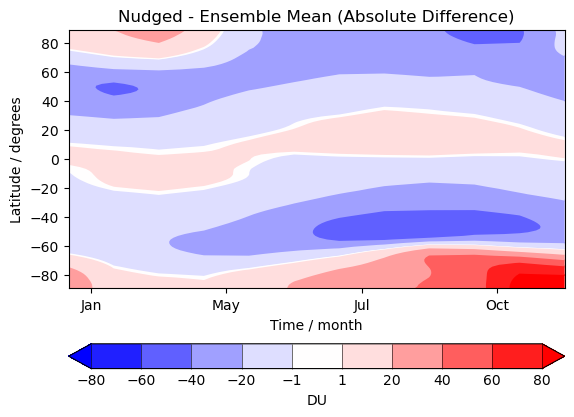

In [7]:
# levels for plotting
clevs=np.array([-80,-60,-40,-20,-1,1,20,40,60,80])
# plot the data
qplt.contourf(abs_zm, clevs, extend='both', cmap=cm.bwr)
# use month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Time / month')
plt.title('Nudged - Ensemble Mean (Absolute Difference)')
plt.show()

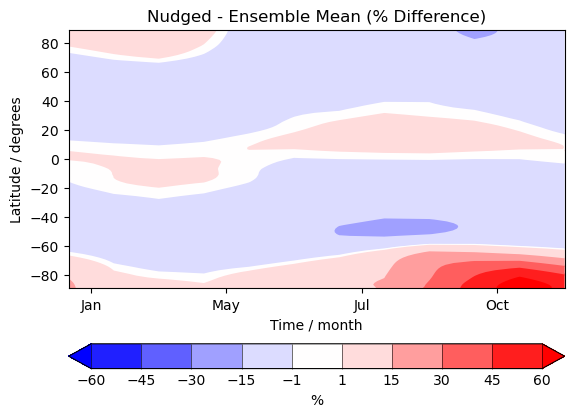

In [8]:
# levels for plotting
clevs=np.array([-60,-45,-30,-15,-1,1,15,30,45,60])
# plot the data
qplt.contourf(pc_zm, clevs, extend='both', cmap=cm.bwr)
# use month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Time / month')
plt.title('Nudged - Ensemble Mean (% Difference)')
plt.show()

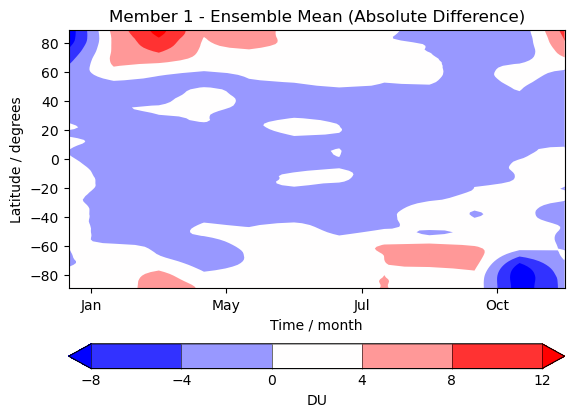

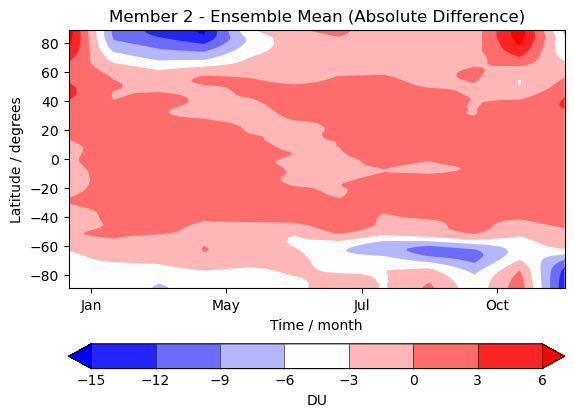

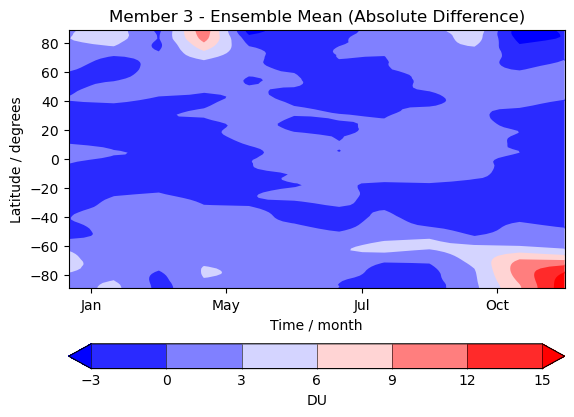

In [9]:
i=0
# plot the data
for cube in ens_abs:
    i += 1
    qplt.contourf(cube, extend='both', cmap=cm.bwr)
    # use month names
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xlabel('Time / month')
    plt.title('Member '+str(i)+' - Ensemble Mean (Absolute Difference)')
    plt.show()

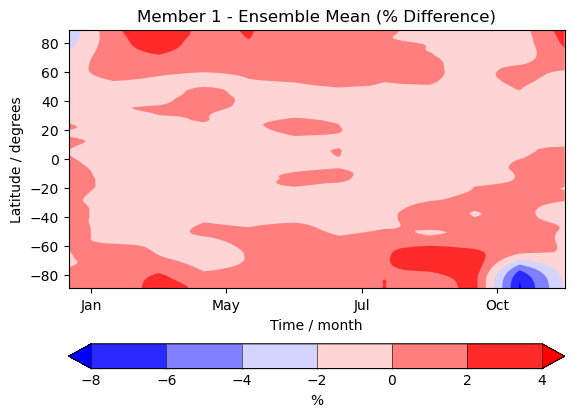

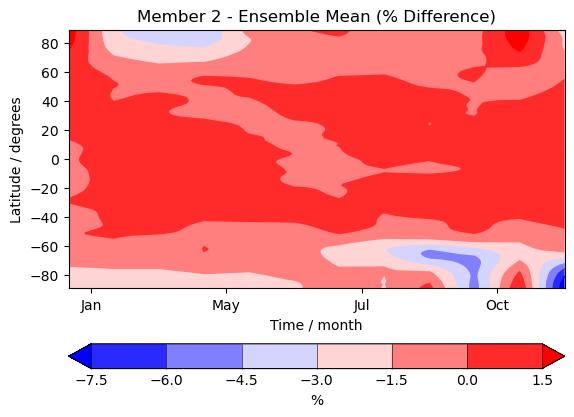

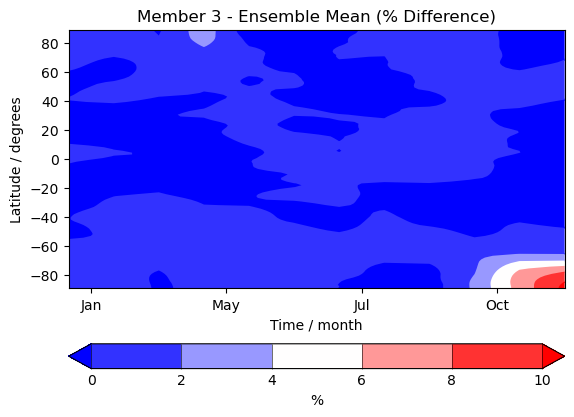

In [10]:
i=0
# plot the data
for cube in ens_pc:
    i += 1
    qplt.contourf(cube, extend='both', cmap=cm.bwr)
    # use month names
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xlabel('Time / month')
    plt.title('Member '+str(i)+' - Ensemble Mean (% Difference)')
    plt.show()